<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/maestria/teoria/06 - Ejercicio - Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Campos de la tabla
* ID: Identificador del cliente
* Year_Birth: Año de nacimiento 
* Education: Nivel de educacion del cliente
* Marital_Status: Estado civil del cliente
* Income: Ingreso del cliente
* Kidhome: Cantidad de niños del cliente
* Teenhome: Cantidad de adolescentes del cliente
* Dt_Customer: Fecha de Alta del cliente
* Recency: Número de días desde la última compra
* MntWines: Monto Gastado en Vinos
* MntFruits: Monto gastado en Frutas
* MntMeatProducts: Monto gastado en alimentos
* MntFishProducts: Monto gastado en pescadería
* MntSweetProducts: Monto gastado en dulces
* MntGoldProds:
* NumDealsPurchases: Productos comprados en ofertas
* NumWebPurchases: Número de compras en la web
* NumCatalogPurchases: Compras de productos de catálogo
* NumStorePurchases:
* NumWebVisitsMonth: Número de visitas por mes
* AcceptedCmp1:
* AcceptedCmp2:
* AcceptedCmp3:
* AcceptedCmp4:
* AcceptedCmp5:
* Complain:
* Z_CostContact:
* Z_Revenue:
* Response:


# Descarga de la base de clientes

In [184]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer



pd.set_option('display.max_columns', None)


import warnings
warnings.filterwarnings('ignore')

urlCustomer = "https://drive.google.com/uc?id=1UtGGi3aUQ_xWBjfc_5Z_3DxWPgdgMgbk"
r = requests.get(urlCustomer)
open("customerSegmentation.txt", "wb").write(r.content)

220188

#Creamos algunas variables

In [185]:
customers = pd.read_csv("customerSegmentation.txt", sep = "\t")

In [186]:
customers['Dt_Customer'] = pd.to_datetime(customers['Dt_Customer'])
customers['Total_Children'] = customers['Kidhome'] + customers['Teenhome']
customers["Is_Parent"] = np.where(customers.Total_Children == 0, 0, 1)
#Campos de Fechas (sobre la fecha de alta de cliente)
customers['Day'] = customers['Dt_Customer'].apply(lambda x: x.day)
customers['Dayofweek'] = customers['Dt_Customer'].apply(lambda x: x.day_name())
customers['Month'] = customers['Dt_Customer'].apply(lambda x: x.month)
customers['Year'] = customers['Dt_Customer'].apply(lambda x: x.year)

customers["Total_Spent"] = customers["MntWines"]+customers["MntFruits"]+customers["MntMeatProducts"]+customers["MntFishProducts"]+customers["MntSweetProducts"]+customers["MntGoldProds"]
customers["Pc_Primary_Goods"] = (customers["MntFruits"]+customers["MntMeatProducts"]+customers["MntFishProducts"]) / customers["Total_Spent"]
customers["Pc_Secondary_Goods"] = (customers["MntWines"]+customers["MntSweetProducts"]+customers["MntGoldProds"]) / customers["Total_Spent"]
customers["Aprox_Age"] = 2015  - customers["Year_Birth"]



In [187]:
print('Income:')
print(customers['Income'].sort_values().tail(5))

print('\nAge:')
print(customers['Aprox_Age'].sort_values().tail(5))

# Get rid of outliers
customers = customers.drop(2233)
customers = customers[customers['Aprox_Age'] < 80]

Income:
2078   NaN
2079   NaN
2081   NaN
2084   NaN
2228   NaN
Name: Income, dtype: float64

Age:
424      74
1950     75
192     115
339     116
239     122
Name: Aprox_Age, dtype: int64


In [188]:
color = "Blues_r"
sns.color_palette(color)

[(0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.16696655132641294, 0.48069204152249134, 0.7291503267973857),
 (0.3262898885044214, 0.6186236063052672, 0.802798923490965),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.8584083044982699, 0.9134486735870818, 0.9645674740484429)]

Text(0.5, 1.05, 'Feature Relationship')

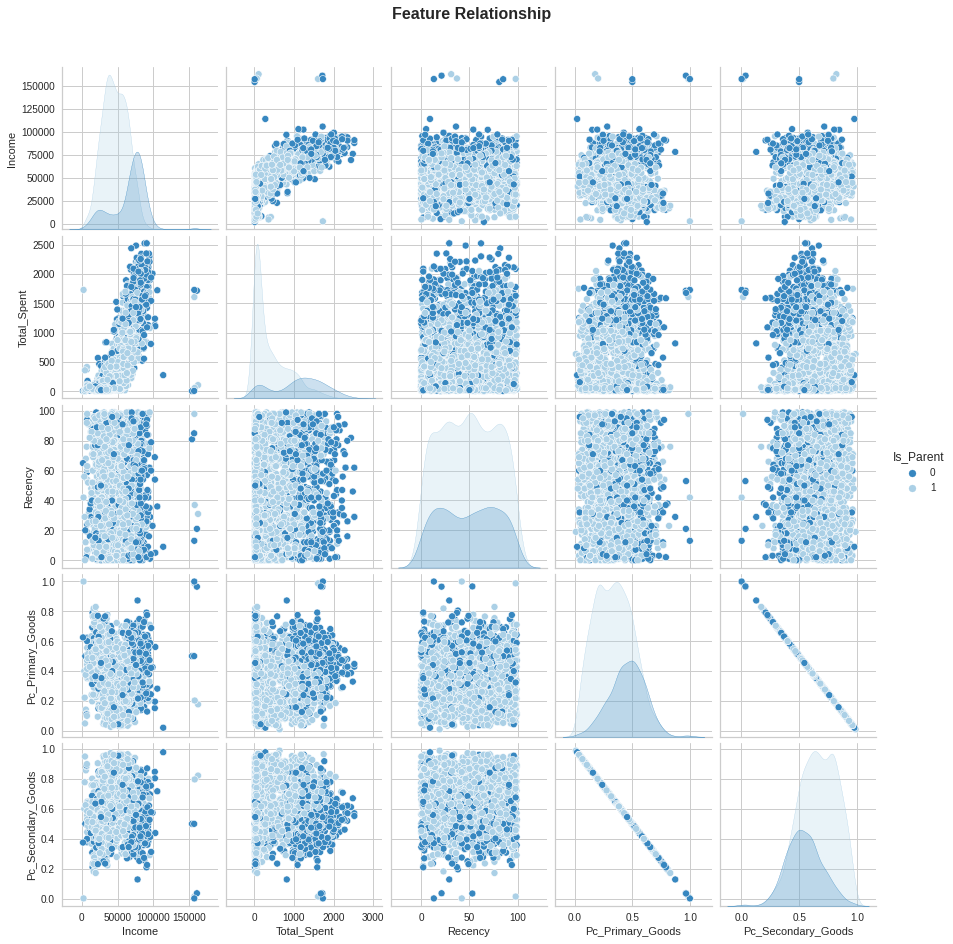

In [189]:
data = ["Income", "Total_Spent", "Recency", "Is_Parent", "Pc_Primary_Goods", "Pc_Secondary_Goods"]
plot = sns.pairplot(customers[data], hue='Is_Parent', palette=color)
plot.fig.suptitle('Feature Relationship', y=1.05, weight='bold', fontsize=16)

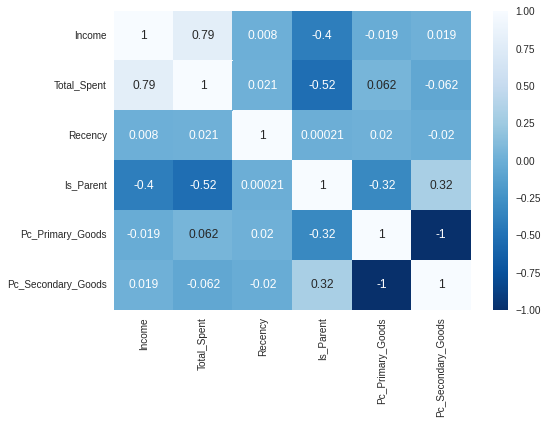

In [190]:
sns.heatmap(customers[data].corr(), cmap = color, annot=True)

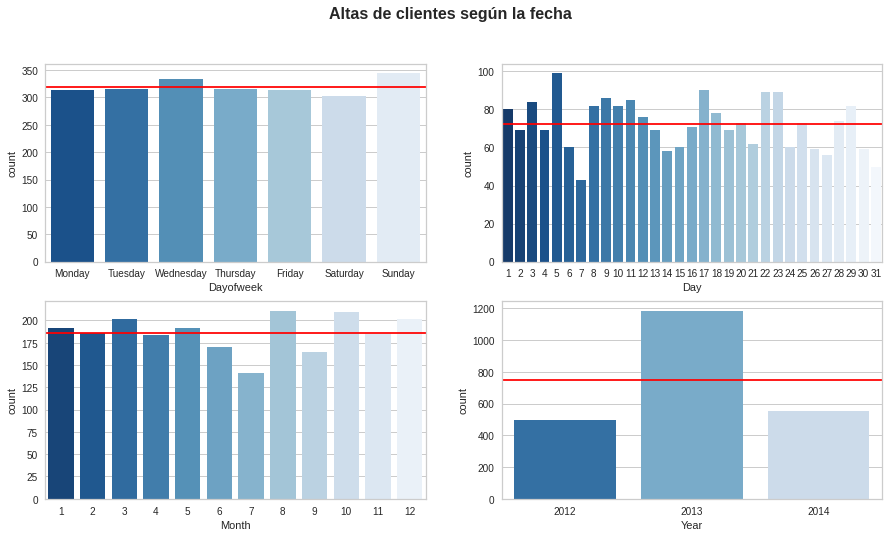

In [191]:
fig, axes = plt.subplots(2,2, figsize=(15,8))
axes = axes.flatten()
fig.suptitle("Altas de clientes según la fecha", weight='bold', fontsize=16)


dayOfWeekGraph = sns.countplot(customers["Dayofweek"], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday","Saturday", "Sunday"], palette=color, ax=axes[0])
dayOfWeekGraph.axhline(customers.groupby("Dayofweek").size().mean(), color = "Red")

DayGraph = sns.countplot(customers["Day"], palette=color, ax=axes[1])
DayGraph.axhline(customers.groupby("Day").size().mean(), color = "Red")

MonthGraph = sns.countplot(customers["Month"], palette=color, ax=axes[2])
MonthGraph.axhline(customers.groupby("Month").size().mean(), color = "Red")

YearGraph = sns.countplot(customers["Year"], palette=color, ax=axes[3])
YearGraph.axhline(customers.groupby("Year").size().mean(), color = "Red")


Text(0.5, 1.0, 'Promedio gastado en productos\nPor bucket de edad')

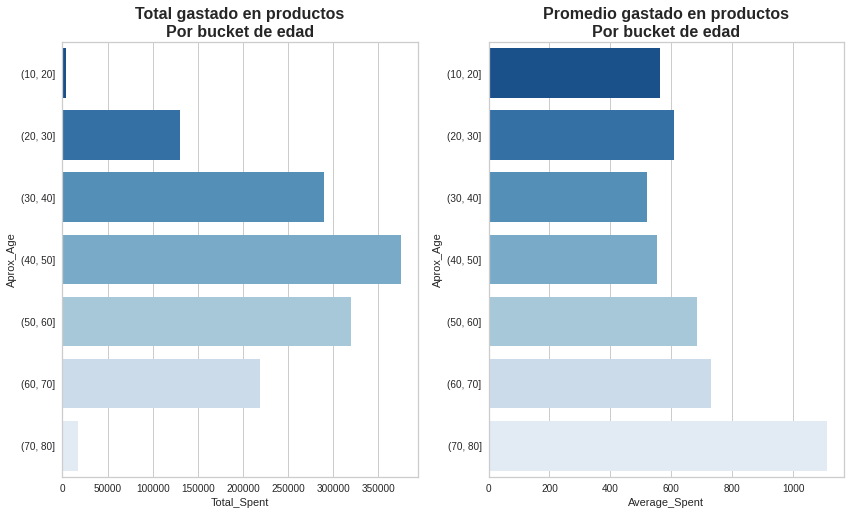

In [192]:
buckets = pd.cut(customers['Aprox_Age'], [10, 20, 30, 40, 50, 60, 70, 80])
buckets.value_counts()
buckets = buckets.to_frame().join(customers[["Total_Spent"]])
buckets["Aprox_Age"] = buckets.Aprox_Age.astype(str)
buckets = buckets.groupby("Aprox_Age").agg({
    "Total_Spent":["sum", "mean"]
})
buckets.columns=["Total_Spent", "Average_Spent"]


fig, axes = plt.subplots(1,2,figsize=(14,8))
axes = axes.flatten()

plots = sns.barplot(x=buckets["Total_Spent"], y=buckets.index, palette=color, ci=None, orient="h", ax=axes[0])
axes[0].set_title('Total gastado en productos\nPor bucket de edad', weight='bold', fontsize=16)


sns.barplot(x=buckets['Average_Spent'], y=buckets.index, palette=color, ci=None, orient='h', ax=axes[1])
axes[1].set_title('Promedio gastado en productos\nPor bucket de edad', weight='bold', fontsize=16)


Text(0.5, 1.0, 'Golds')

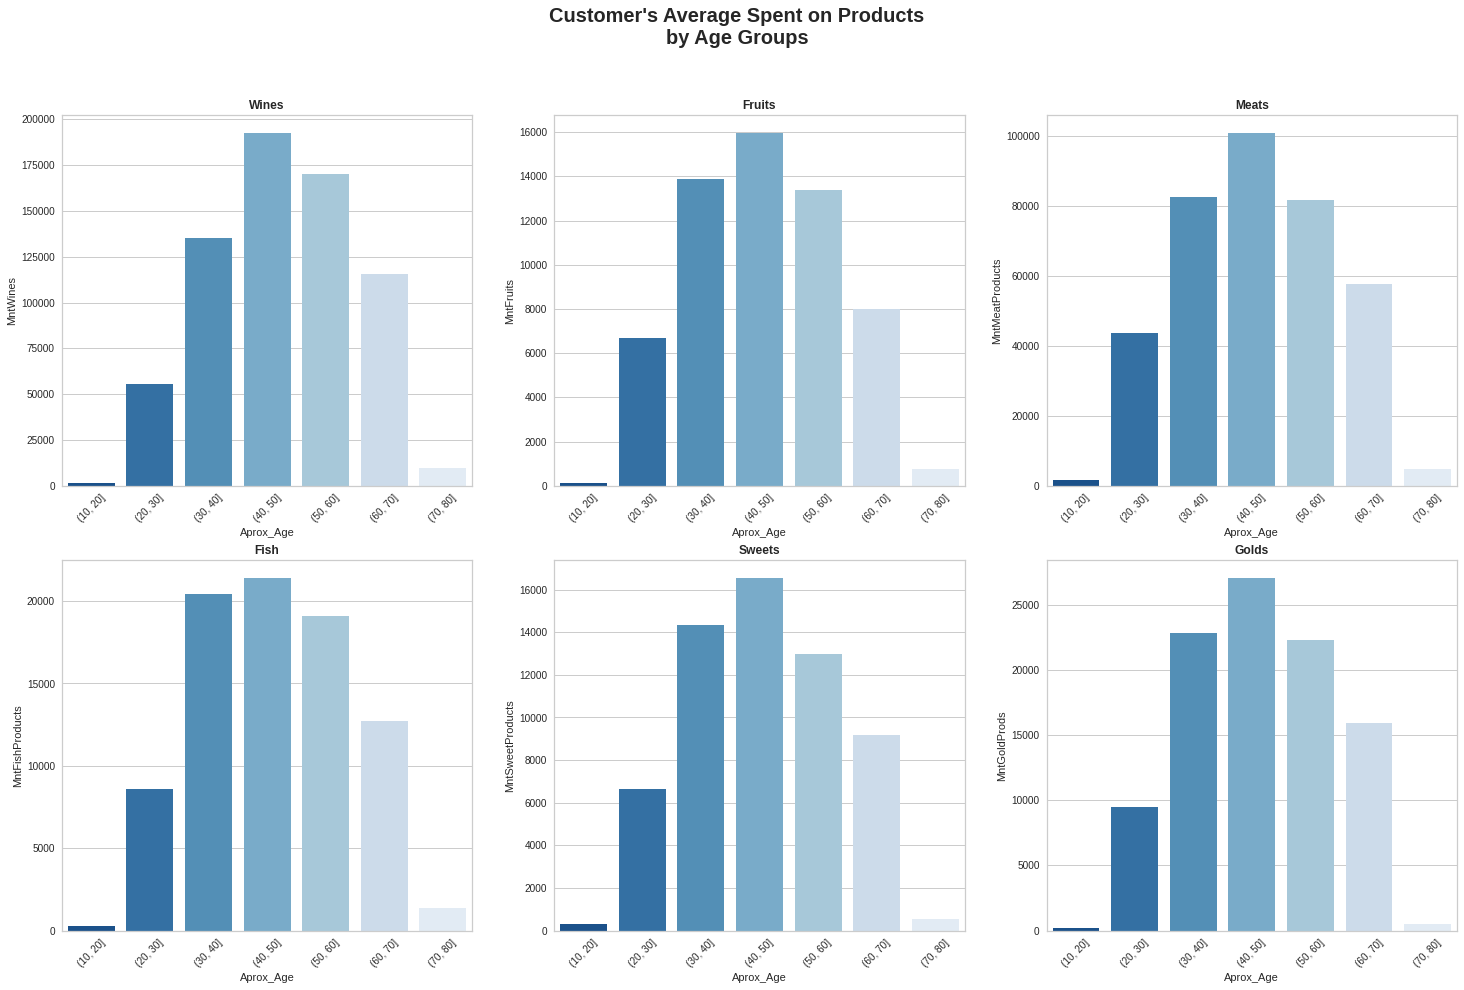

In [195]:
buckets = pd.cut(customers['Aprox_Age'], [10, 20, 30, 40, 50, 60, 70, 80])
buckets.value_counts()
buckets = buckets.to_frame().join(customers[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]])
buckets["Aprox_Age"] = buckets.Aprox_Age.astype(str)
buckets = buckets.groupby("Aprox_Age").agg({
    "MntWines":["sum"],
    "MntFruits":["sum"],
    "MntMeatProducts":["sum"],
    "MntFishProducts":["sum"],
    "MntSweetProducts":["sum"],
    "MntGoldProds": ["sum"]
})
buckets.columns=["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]


fig, axes = plt.subplots(2,3,figsize=(25,15))
axes = axes.flatten()

fig.suptitle("Customer's Average Spent on Products\nby Age Groups", weight='bold', fontsize=20)


# Bar plot
sns.barplot(x=buckets.index, y=buckets["MntWines"], palette=color, ci=None, ax=axes[0], )
axes[0].set_xticklabels(buckets.index, Rotation = 45 )
axes[0].set_title('Wines', weight='bold')

sns.barplot(x=buckets.index, y=buckets["MntFruits"], palette=color, ci=None, ax=axes[1], )
axes[1].set_xticklabels(buckets.index, Rotation = 45 )
axes[1].set_title('Fruits', weight='bold')

sns.barplot(x=buckets.index, y=buckets["MntMeatProducts"], palette=color, ci=None, ax=axes[2], )
axes[2].set_xticklabels(buckets.index, Rotation = 45 )
axes[2].set_title('Meats', weight='bold')

sns.barplot(x=buckets.index, y=buckets["MntFishProducts"], palette=color, ci=None, ax=axes[3], )
axes[3].set_xticklabels(buckets.index, Rotation = 45 )
axes[3].set_title('Fish', weight='bold')

sns.barplot(x=buckets.index, y=buckets["MntSweetProducts"], palette=color, ci=None, ax=axes[4], )
axes[4].set_xticklabels(buckets.index, Rotation = 45 )
axes[4].set_title('Sweets', weight='bold')

sns.barplot(x=buckets.index, y=buckets["MntGoldProds"], palette=color, ci=None, ax=axes[5], )
axes[5].set_xticklabels(buckets.index, Rotation = 45 )
axes[5].set_title('Golds', weight='bold')



# Terminamos de imputar valores y escalamos los datos

In [197]:
customers["Income"] = np.where(customers.Income.isnull(), customers.Income.mean(), customers.Income)

In [198]:
#Creamos Variables dummies
obj_feat = customers.select_dtypes(exclude=[np.number]).columns

dummies = pd.get_dummies(customers[obj_feat], drop_first=True)
df_final = pd.concat([customers, dummies], axis=1)
df_final.drop(obj_feat, axis=1, inplace=True)

#Escalamos
scaler = StandardScaler()
scaled = scaler.fit_transform(df_final)

df_final_scaled = pd.DataFrame(scaled, columns=df_final.columns)
df_final_scaled.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Total_Children,Is_Parent,Day,Month,Year,Total_Spent,Pc_Primary_Goods,Pc_Secondary_Goods,Aprox_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Dayofweek_Monday,Dayofweek_Saturday,Dayofweek_Sunday,Dayofweek_Thursday,Dayofweek_Tuesday,Dayofweek_Wednesday
0,-0.020039,-1.016868,0.288658,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,0.348738,1.407639,2.509801,-0.552429,0.692865,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,0.0,0.0,2.386338,-1.264308,-1.584362,-0.744945,-0.717535,-1.500981,1.680176,0.754423,-0.754423,1.016868,-0.157315,0.992870,-0.445292,-0.526293,-0.036654,-0.339429,-0.793560,1.915218,-0.590434,-0.188851,-0.029921,2.478663,-0.395918,-0.426401,-0.404941,-0.404941,-0.418314
1,-1.052682,-1.273264,-0.262293,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,-0.168700,-1.110921,-0.568970,-1.167738,-0.131421,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,0.0,0.0,-0.419052,1.395139,0.631169,-1.424220,0.421151,1.419988,-0.962202,-0.217885,0.217885,1.273264,-0.157315,0.992870,-0.445292,-0.526293,-0.036654,-0.339429,-0.793560,1.915218,-0.590434,-0.188851,-0.029921,-0.403443,-0.395918,2.345208,-0.404941,-0.404941,-0.418314
2,-0.446351,-0.333146,0.918137,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,-0.686137,1.407639,-0.226884,1.293496,-0.543564,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,0.0,0.0,-0.419052,-1.264308,-1.584362,0.613606,0.421151,-0.040496,0.282541,-0.002885,0.002885,0.333146,-0.157315,0.992870,-0.445292,-0.526293,-0.036654,-0.339429,-0.793560,-0.522134,1.693668,-0.188851,-0.029921,-0.403443,-0.395918,-0.426401,-0.404941,-0.404941,2.390547
3,0.182791,1.290693,-1.182477,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,-0.168700,-0.751127,-0.911056,-0.552429,0.280722,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,0.0,0.0,-0.419052,0.065416,0.631169,-1.537433,0.990494,1.419988,-0.918994,1.596802,-1.596802,-1.290693,-0.157315,0.992870,-0.445292,-0.526293,-0.036654,-0.339429,-0.793560,-0.522134,1.693668,-0.188851,-0.029921,-0.403443,-0.395918,-0.426401,2.469496,-0.404941,-0.418314
4,-0.081689,1.034298,0.295899,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,1.383614,0.328256,0.115201,0.062879,-0.131421,-0.28041,-0.284104,-0.279482,-0.262362,-0.116616,-0.095001,0.0,0.0,-0.419052,0.065416,0.631169,0.387181,-1.571549,1.419988,-0.305762,0.707712,-0.707712,-1.034298,-0.157315,-1.007181,-0.445292,1.900081,-0.036654,-0.339429,1.260144,-0.522134,-0.590434,-0.188851,-0.029921,-0.403443,-0.395918,2.345208,-0.404941,-0.404941,-0.418314


## Revisamos con el algoritmo del Codo el número correcto de K

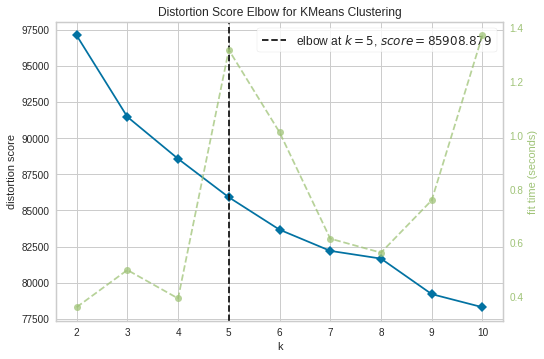

In [199]:
elbow = KElbowVisualizer(KMeans(random_state=123), k=10)
elbow.fit(df_final_scaled)
elbow.show()

In [200]:
model = KMeans(n_clusters=5, random_state=123)
yhat = model.fit_predict(df_final_scaled)
customers['Cluster'] = yhat

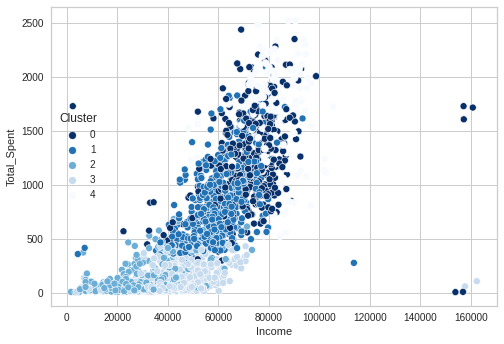

In [201]:

sns.scatterplot(data=customers, x='Income', y='Total_Spent', hue='Cluster', palette=color)

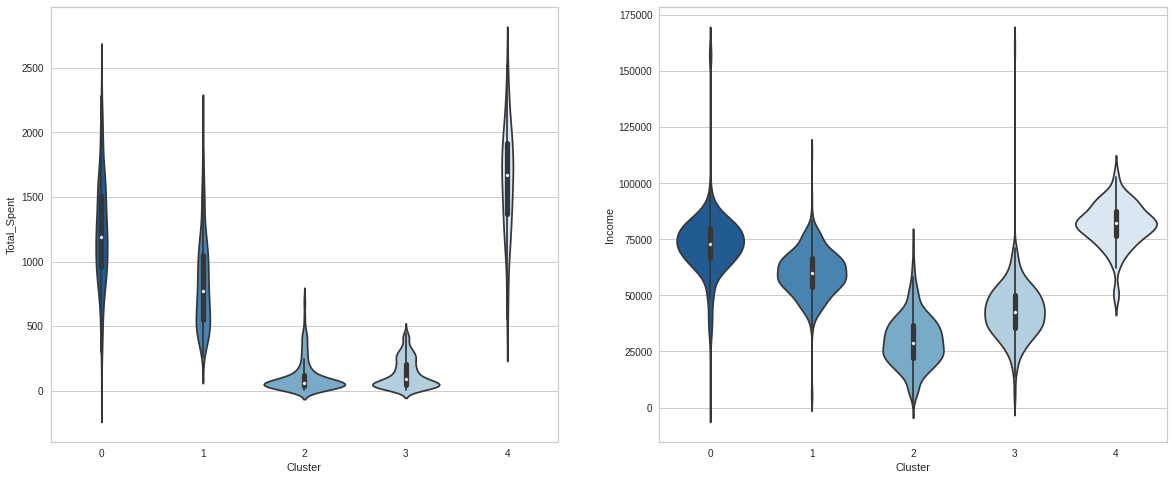

In [204]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
axes = axes.flatten()

sns.violinplot(data=customers, x='Cluster', y='Total_Spent', palette=color, ax=axes[0])
sns.violinplot(data=customers, x='Cluster', y='Income', palette=color, ax=axes[1])

Text(0.6, 3900, '0: Non Parent\n1: Parent')

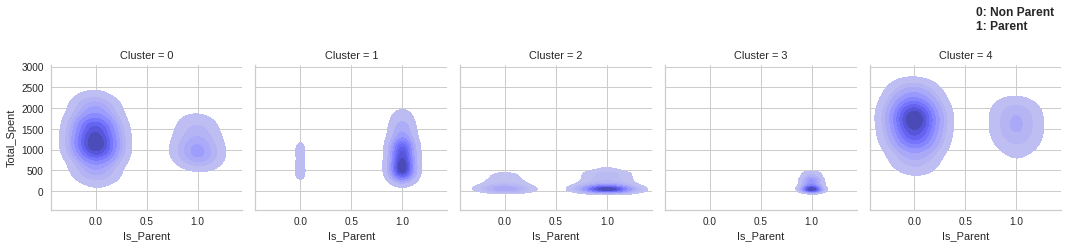

In [206]:
g = sns.FacetGrid(data=customers, col='Cluster')
g.map(sns.kdeplot, 'Is_Parent', 'Total_Spent', color='blue', fill=True)

plt.text(0.6,3900, '0: Non Parent\n1: Parent', weight='bold', fontsize=12)